# Hangman Solver: HMM + RL Training Pipeline
Train an agent that combines HMM pattern analysis with Deep Q-Learning

In [37]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, Counter
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

## 1. Load Corpus and Build HMM Components

In [38]:
# Load corpus
with open('corpus.txt', 'r', encoding='utf-8') as f:
    corpus_raw = f.read().splitlines()

# Clean and filter
corpus = []
for word in corpus_raw:
    word = word.strip().lower()
    if word and word.isalpha() and len(word) >= 3:
        corpus.append(word)

corpus = list(set(corpus))  # Deduplicate
print(f"Loaded {len(corpus)} unique words")
print(f"Sample words: {random.sample(corpus, 10)}")

Loaded 49304 unique words
Sample words: ['mistreat', 'daybook', 'aerostatics', 'spanishly', 'desolating', 'humanitarianize', 'vaccinoid', 'zoquean', 'polonium', 'docimastic']


In [39]:
# Build character n-gram language model for HMM
def build_ngram_model(words, n=3):
    """Build character n-gram frequency model"""
    ngrams = Counter()
    for word in words:
        padded = '^' * (n-1) + word + '$'
        for i in range(len(padded) - n + 1):
            ngrams[padded[i:i+n]] += 1
    return ngrams

trigrams = build_ngram_model(corpus, n=3)
bigrams = build_ngram_model(corpus, n=2)
unigrams = build_ngram_model(corpus, n=1)

print(f"Built n-gram models: {len(trigrams)} trigrams, {len(bigrams)} bigrams, {len(unigrams)} unigrams")

Built n-gram models: 9164 trigrams, 728 bigrams, 27 unigrams


In [40]:
# Build length-based word index for efficient lookup
words_by_length = {}
for word in corpus:
    length = len(word)
    if length not in words_by_length:
        words_by_length[length] = []
    words_by_length[length].append(word)

print(f"Word length distribution: {[(k, len(v)) for k, v in sorted(words_by_length.items())[:10]]}")

Word length distribution: [(3, 310), (4, 1077), (5, 2154), (6, 3716), (7, 5038), (8, 6306), (9, 6778), (10, 6454), (11, 5437), (12, 4292)]


## 2. HMM Pattern Matcher

In [41]:
class HMMPatternMatcher:
    """HMM-based pattern analysis for Hangman"""
    
    def __init__(self, corpus, words_by_length, trigrams, bigrams, unigrams):
        self.corpus = corpus
        self.words_by_length = words_by_length
        self.trigrams = trigrams
        self.bigrams = bigrams
        self.unigrams = unigrams
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
        
    def match_pattern(self, pattern, guessed_letters):
        """Find words matching current pattern"""
        length = len(pattern)
        candidates = self.words_by_length.get(length, [])
        
        # Filter by pattern
        matches = []
        for word in candidates:
            if self._matches_pattern(word, pattern, guessed_letters):
                matches.append(word)
        
        return matches
    
    def _matches_pattern(self, word, pattern, guessed_letters):
        """Check if word matches pattern and constraints"""
        if len(word) != len(pattern):
            return False
        
        for w_char, p_char in zip(word, pattern):
            if p_char != '_' and w_char != p_char:
                return False
            if p_char == '_' and w_char in guessed_letters:
                return False
        
        return True
    
    def get_letter_probabilities(self, pattern, guessed_letters):
        """Output 26-dim probability vector based on HMM analysis"""
        matches = self.match_pattern(pattern, guessed_letters)
        
        if not matches:
            # Fallback to character language model
            return self._lm_fallback(pattern, guessed_letters)
        
        # Count letter frequencies in matching positions
        letter_counts = Counter()
        for word in matches:
            for i, char in enumerate(word):
                if pattern[i] == '_' and char not in guessed_letters:
                    letter_counts[char] += 1
        
        # Convert to probability distribution
        probs = np.zeros(26)
        total = sum(letter_counts.values())
        
        if total > 0:
            for letter, count in letter_counts.items():
                idx = ord(letter) - ord('a')
                probs[idx] = count / total
        else:
            # Uniform if no valid letters
            available = [c for c in self.alphabet if c not in guessed_letters]
            if available:
                for c in available:
                    probs[ord(c) - ord('a')] = 1.0 / len(available)
        
        return probs
    
    def _lm_fallback(self, pattern, guessed_letters):
        """Use character LM when no pattern matches"""
        probs = np.zeros(26)
        
        # Score each available letter by trigram likelihood
        for letter in self.alphabet:
            if letter not in guessed_letters:
                score = 0
                # Check each position in pattern
                for i in range(len(pattern)):
                    if pattern[i] == '_':
                        # Build context safely
                        # Left context (previous character)
                        if i >= 1:
                            left_char = pattern[i-1]
                        else:
                            left_char = '^'
                        
                        # Right context (next character)
                        if i < len(pattern) - 1:
                            right_char = pattern[i+1]
                        else:
                            right_char = '$'
                        
                        # Trigram score
                        context = left_char + letter + right_char
                        score += self.trigrams.get(context, 0) + 1
                
                idx = ord(letter) - ord('a')
                probs[idx] = score
        
        # Normalize
        total = probs.sum()
        if total > 0:
            probs /= total
        else:
            available = [c for c in self.alphabet if c not in guessed_letters]
            if available:
                for c in available:
                    probs[ord(c) - ord('a')] = 1.0 / len(available)
        
        return probs

# Initialize HMM matcher
hmm_matcher = HMMPatternMatcher(corpus, words_by_length, trigrams, bigrams, unigrams)
print("HMM Pattern Matcher initialized")

HMM Pattern Matcher initialized


## 3. Hangman Game Environment

In [42]:
class HangmanGame:
    """Hangman game environment"""
    
    def __init__(self, word, max_lives=6):
        self.word = word.lower()
        self.max_lives = max_lives
        self.reset()
    
    def reset(self):
        self.lives = self.max_lives
        self.guessed_letters = set()
        self.pattern = ['_'] * len(self.word)
        self.won = False
        self.lost = False
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        return self.get_state()
    
    def get_pattern_str(self):
        return ''.join(self.pattern)
    
    def is_done(self):
        return self.won or self.lost
    
    def guess(self, letter):
        """Make a guess and return (reward, done)"""
        letter = letter.lower()
        
        # Check if already guessed (penalty)
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return -2.0, self.is_done()  # Heavy penalty for repeat
        
        self.guessed_letters.add(letter)
        
        # Check if letter is in word
        if letter in self.word:
            # Reveal all instances
            count = 0
            for i, char in enumerate(self.word):
                if char == letter:
                    self.pattern[i] = letter
                    count += 1
            
            # Check win condition
            if '_' not in self.pattern:
                self.won = True
                return 10.0, True  # Big reward for winning
            
            # Reward proportional to letters revealed
            return 1.0 * count, False
        else:
            # Wrong guess
            self.lives -= 1
            self.wrong_guesses += 1
            
            if self.lives <= 0:
                self.lost = True
                return -10.0, True  # Big penalty for losing
            
            return -1.0, False  # Penalty for wrong guess
    
    def get_state(self):
        """Return current game state"""
        return {
            'pattern': self.get_pattern_str(),
            'guessed_letters': self.guessed_letters.copy(),
            'lives': self.lives,
            'word_length': len(self.word),
            'revealed': sum(1 for c in self.pattern if c != '_'),
            'remaining': sum(1 for c in self.pattern if c == '_')
        }

print("Hangman Game Environment created")

Hangman Game Environment created


## 4. Deep Q-Network Architecture

In [43]:
class DQN(nn.Module):
    """Deep Q-Network for action-value estimation"""
    
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        
        # State size = 26 (HMM probs) + 26 (guessed mask) + 6 (game context)
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, action_size)
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)  # Q-values for all actions
        return x

print("DQN Architecture defined")

DQN Architecture defined


## 5. Experience Replay Buffer

In [44]:
class ReplayBuffer:
    """Experience replay buffer for DQN"""
    
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

print("Replay Buffer defined")

Replay Buffer defined


## 6. RL Agent with State Building

In [45]:
class RLAgent:
    """RL Agent that combines HMM output with game context"""
    
    def __init__(self, hmm_matcher, state_size=58, action_size=26, 
                 learning_rate=0.001, gamma=0.95, epsilon_start=1.0, 
                 epsilon_end=0.01, epsilon_decay=0.995):
        
        self.hmm_matcher = hmm_matcher
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Q-network and target network
        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer()
        
        self.alphabet = 'abcdefghijklmnopqrstuvwxyz'
    
    def build_state_vector(self, game_state):
        """Build state vector: HMM probs (26) + guessed mask (26) + game context (6)"""
        # 1. Get HMM probability distribution
        hmm_probs = self.hmm_matcher.get_letter_probabilities(
            game_state['pattern'], 
            game_state['guessed_letters']
        )
        
        # 2. Guessed letters mask (1 if guessed, 0 otherwise)
        guessed_mask = np.zeros(26)
        for letter in game_state['guessed_letters']:
            idx = ord(letter) - ord('a')
            guessed_mask[idx] = 1.0
        
        # 3. Game context features
        context = np.array([
            game_state['lives'] / 6.0,  # Normalized lives remaining
            game_state['revealed'] / game_state['word_length'],  # Progress
            game_state['remaining'] / game_state['word_length'],  # Remaining blanks
            len(game_state['guessed_letters']) / 26.0,  # Guess exhaustion
            game_state['word_length'] / 20.0,  # Normalized word length
            1.0 if game_state['lives'] <= 2 else 0.0  # Urgency flag
        ])
        
        # Concatenate all features
        state_vector = np.concatenate([hmm_probs, guessed_mask, context])
        return state_vector
    
    def select_action(self, state_vector, valid_actions):
        """ε-greedy action selection"""
        # Exploration: random valid action
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        # Exploitation: best Q-value among valid actions
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vector).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor).cpu().numpy()[0]
            
            # Mask invalid actions
            masked_q = np.full(26, -np.inf)
            for action in valid_actions:
                masked_q[action] = q_values[action]
            
            return np.argmax(masked_q)
    
    def train_step(self, batch_size=64):
        """Sample mini-batch and update Q-function"""
        if len(self.replay_buffer) < batch_size:
            return None
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q-values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q-values (Double DQN)
        with torch.no_grad():
            next_actions = self.q_network(next_states).argmax(1)
            next_q = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy weights from Q-network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

print("RL Agent defined")

RL Agent defined


## 7. Training Loop

In [46]:
def get_valid_actions(guessed_letters):
    """Return list of valid action indices (letters not yet guessed)"""
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    return [i for i, letter in enumerate(alphabet) if letter not in guessed_letters]

def action_to_letter(action):
    """Convert action index to letter"""
    return chr(ord('a') + action)

print("Helper functions defined")

Helper functions defined


In [47]:
def train_agent(agent, corpus, num_episodes=10000, batch_size=64, 
                target_update_freq=100, save_freq=1000):
    """Main training loop following the workflow"""
    
    stats = {
        'wins': [],
        'losses': [],
        'wrong_guesses': [],
        'repeated_guesses': [],
        'episode_rewards': [],
        'losses_train': [],
        'epsilon': []
    }
    
    for episode in tqdm(range(num_episodes), desc="Training"):
        # GAME STARTS - Pick random word from corpus
        word = random.choice(corpus)
        game = HangmanGame(word)
        
        # Initialize game state (all blanks, 6 lives, no guesses)
        game_state = game.get_state()
        episode_reward = 0
        
        # GAME LOOP (until win or lose)
        while not game.is_done():
            # 1. HMM analyzes current pattern → Outputs 26-dim probability vector
            # 2. RL agent builds state vector → Includes HMM probs + game context
            state_vector = agent.build_state_vector(game_state)
            
            # Get valid actions
            valid_actions = get_valid_actions(game_state['guessed_letters'])
            
            if not valid_actions:
                break  # Safety check
            
            # 3. Neural network forward pass → Outputs Q(s,a) for all 26 letters
            # 4. Action selection (ε-greedy) → Choose letter to guess
            action = agent.select_action(state_vector, valid_actions)
            letter = action_to_letter(action)
            
            # 5. Execute guess → Update game state → Calculate reward
            reward, done = game.guess(letter)
            episode_reward += reward
            
            # Get next state
            next_game_state = game.get_state()
            next_state_vector = agent.build_state_vector(next_game_state)
            
            # 6. Store experience in replay buffer
            agent.replay_buffer.push(state_vector, action, reward, next_state_vector, done)
            
            # 7. Sample mini-batch and train network → Update Q-function
            loss = agent.train_step(batch_size)
            if loss is not None:
                stats['losses_train'].append(loss)
            
            # 8. Update state and repeat
            game_state = next_game_state
        
        # GAME ENDS (win or lose)
        # Record: win/loss, wrong guesses, repeated guesses
        stats['wins'].append(1 if game.won else 0)
        stats['losses'].append(1 if game.lost else 0)
        stats['wrong_guesses'].append(game.wrong_guesses)
        stats['repeated_guesses'].append(game.repeated_guesses)
        stats['episode_rewards'].append(episode_reward)
        stats['epsilon'].append(agent.epsilon)
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Update target network periodically
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        # Print progress
        if (episode + 1) % 500 == 0:
            recent_wins = sum(stats['wins'][-500:])
            recent_reward = np.mean(stats['episode_rewards'][-500:])
            recent_wrong = np.mean(stats['wrong_guesses'][-500:])
            print(f"\nEpisode {episode+1}/{num_episodes}")
            print(f"  Win rate (last 500): {recent_wins/500:.2%}")
            print(f"  Avg reward: {recent_reward:.2f}")
            print(f"  Avg wrong guesses: {recent_wrong:.2f}")
            print(f"  Epsilon: {agent.epsilon:.3f}")
        
        # Save checkpoint
        if (episode + 1) % save_freq == 0:
            torch.save({
                'episode': episode,
                'q_network_state_dict': agent.q_network.state_dict(),
                'target_network_state_dict': agent.target_network.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon,
                'stats': stats
            }, f'checkpoint_ep{episode+1}.pth')
    
    return stats

print("Training function defined")

Training function defined


## 8. Initialize and Train

In [48]:
# Initialize agent
agent = RLAgent(
    hmm_matcher=hmm_matcher,
    state_size=58,  # 26 (HMM) + 26 (guessed) + 6 (context)
    action_size=26,
    learning_rate=0.0005,
    gamma=0.95,
    epsilon_start=1.0,
    epsilon_end=0.01,
    epsilon_decay=0.9995
)

print(f"Agent initialized on device: {agent.device}")
print(f"Q-Network parameters: {sum(p.numel() for p in agent.q_network.parameters())}")

Agent initialized on device: cpu
Q-Network parameters: 117146


In [49]:
# Train the agent
print("Starting training...\n")
stats = train_agent(
    agent=agent,
    corpus=corpus,
    num_episodes=10000,
    batch_size=64,
    target_update_freq=100,
    save_freq=2000
)

print("\n" + "="*50)
print("Training Complete!")
print("="*50)

Starting training...



Training:   5%|▌         | 502/10000 [01:01<17:01,  9.30it/s]


Episode 500/10000
  Win rate (last 500): 0.80%
  Avg reward: -11.34
  Avg wrong guesses: 5.99
  Epsilon: 0.779


Training:  10%|▉         | 999/10000 [02:11<18:49,  7.97it/s]


Episode 1000/10000
  Win rate (last 500): 1.60%
  Avg reward: -11.13
  Avg wrong guesses: 5.97
  Epsilon: 0.606


Training:  15%|█▌        | 1500/10000 [03:27<13:32, 10.46it/s]


Episode 1500/10000
  Win rate (last 500): 4.80%
  Avg reward: -9.46
  Avg wrong guesses: 5.91
  Epsilon: 0.472


Training:  20%|██        | 2001/10000 [04:19<13:36,  9.80it/s]


Episode 2000/10000
  Win rate (last 500): 13.40%
  Avg reward: -6.15
  Avg wrong guesses: 5.77
  Epsilon: 0.368


Training:  25%|██▌       | 2502/10000 [05:14<11:34, 10.79it/s]


Episode 2500/10000
  Win rate (last 500): 35.20%
  Avg reward: -0.67
  Avg wrong guesses: 5.26
  Epsilon: 0.286


Training:  30%|███       | 3001/10000 [06:19<18:58,  6.15it/s]


Episode 3000/10000
  Win rate (last 500): 37.00%
  Avg reward: -0.60
  Avg wrong guesses: 5.22
  Epsilon: 0.223


Training:  35%|███▌      | 3501/10000 [07:54<20:25,  5.30it/s]


Episode 3500/10000
  Win rate (last 500): 44.40%
  Avg reward: 0.96
  Avg wrong guesses: 5.28
  Epsilon: 0.174


Training:  40%|████      | 4001/10000 [09:19<11:59,  8.34it/s]


Episode 4000/10000
  Win rate (last 500): 46.60%
  Avg reward: 1.19
  Avg wrong guesses: 5.34
  Epsilon: 0.135


Training:  45%|████▌     | 4500/10000 [10:45<21:26,  4.28it/s]


Episode 4500/10000
  Win rate (last 500): 56.80%
  Avg reward: 3.69
  Avg wrong guesses: 5.10
  Epsilon: 0.105


Training:  50%|█████     | 5001/10000 [12:21<12:00,  6.94it/s]


Episode 5000/10000
  Win rate (last 500): 59.40%
  Avg reward: 4.44
  Avg wrong guesses: 5.07
  Epsilon: 0.082


Training:  55%|█████▌    | 5501/10000 [13:57<13:01,  5.76it/s]


Episode 5500/10000
  Win rate (last 500): 72.60%
  Avg reward: 7.73
  Avg wrong guesses: 4.83
  Epsilon: 0.064


Training:  60%|██████    | 6000/10000 [15:10<08:10,  8.15it/s]


Episode 6000/10000
  Win rate (last 500): 82.20%
  Avg reward: 10.14
  Avg wrong guesses: 4.47
  Epsilon: 0.050


Training:  65%|██████▌   | 6501/10000 [16:45<07:37,  7.65it/s]


Episode 6500/10000
  Win rate (last 500): 87.20%
  Avg reward: 11.41
  Avg wrong guesses: 4.30
  Epsilon: 0.039


Training:  70%|███████   | 7000/10000 [18:25<11:55,  4.19it/s]


Episode 7000/10000
  Win rate (last 500): 92.20%
  Avg reward: 13.20
  Avg wrong guesses: 3.88
  Epsilon: 0.030


Training:  75%|███████▌  | 7500/10000 [20:06<09:42,  4.29it/s]


Episode 7500/10000
  Win rate (last 500): 91.00%
  Avg reward: 13.10
  Avg wrong guesses: 3.43
  Epsilon: 0.023


Training:  80%|████████  | 8000/10000 [21:48<07:30,  4.44it/s]


Episode 8000/10000
  Win rate (last 500): 91.40%
  Avg reward: 13.29
  Avg wrong guesses: 3.22
  Epsilon: 0.018


Training:  85%|████████▌ | 8500/10000 [23:25<02:58,  8.41it/s]


Episode 8500/10000
  Win rate (last 500): 93.80%
  Avg reward: 14.43
  Avg wrong guesses: 2.91
  Epsilon: 0.014


Training:  90%|█████████ | 9001/10000 [24:24<01:44,  9.59it/s]


Episode 9000/10000
  Win rate (last 500): 94.20%
  Avg reward: 14.63
  Avg wrong guesses: 2.71
  Epsilon: 0.011


Training:  95%|█████████▌| 9501/10000 [25:21<01:02,  7.99it/s]


Episode 9500/10000
  Win rate (last 500): 95.00%
  Avg reward: 14.85
  Avg wrong guesses: 2.67
  Epsilon: 0.010


Training: 100%|██████████| 10000/10000 [26:19<00:00,  6.33it/s]


Episode 10000/10000
  Win rate (last 500): 94.00%
  Avg reward: 14.72
  Avg wrong guesses: 2.59
  Epsilon: 0.010

Training Complete!


## 9. Save Final Model

In [50]:
# Save final trained model
torch.save({
    'q_network_state_dict': agent.q_network.state_dict(),
    'target_network_state_dict': agent.target_network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'stats': stats
}, 'hangman_hmm_rl_final.pth')

# Save HMM components
with open('hmm_components.pkl', 'wb') as f:
    pickle.dump({
        'trigrams': trigrams,
        'bigrams': bigrams,
        'unigrams': unigrams,
        'words_by_length': words_by_length,
        'corpus': corpus
    }, f)

print("Model and HMM components saved!")

Model and HMM components saved!


## 10. Visualize Training Progress

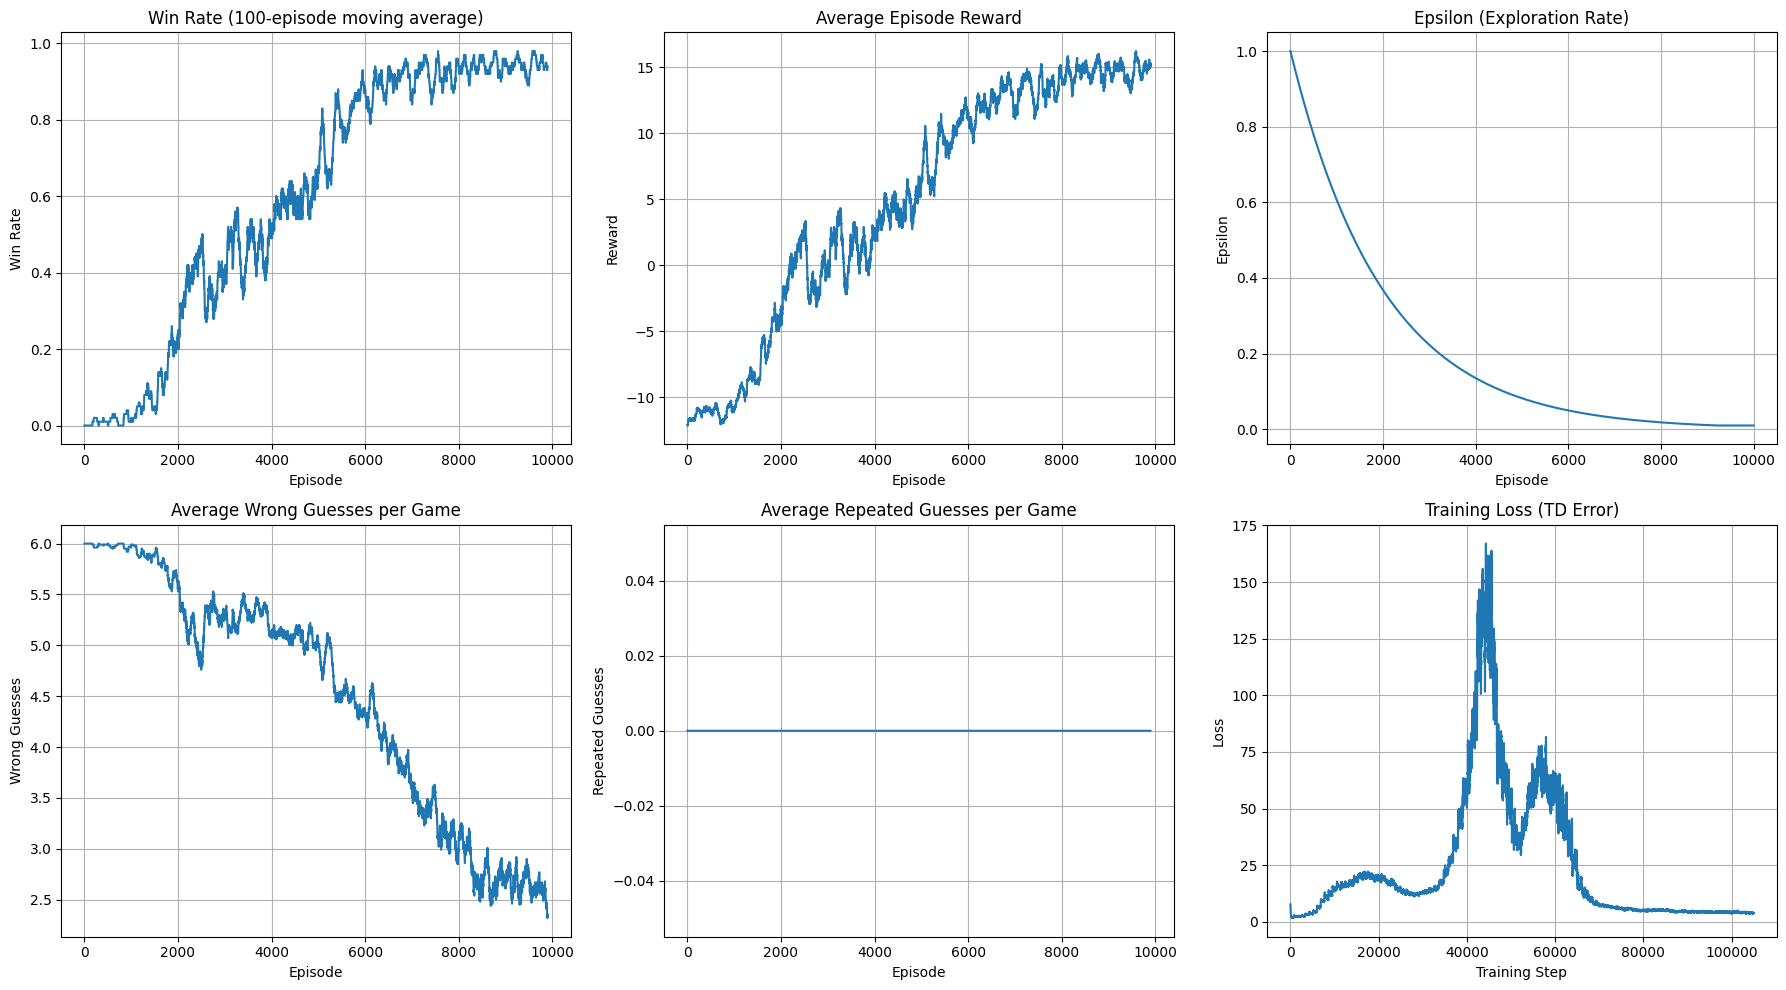

Training visualizations saved!


In [51]:
# Plot training statistics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Win rate over time
window = 100
win_rate = np.convolve(stats['wins'], np.ones(window)/window, mode='valid')
axes[0, 0].plot(win_rate)
axes[0, 0].set_title('Win Rate (100-episode moving average)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Win Rate')
axes[0, 0].grid(True)

# Episode rewards
rewards_smooth = np.convolve(stats['episode_rewards'], np.ones(window)/window, mode='valid')
axes[0, 1].plot(rewards_smooth)
axes[0, 1].set_title('Average Episode Reward')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].grid(True)

# Epsilon decay
axes[0, 2].plot(stats['epsilon'])
axes[0, 2].set_title('Epsilon (Exploration Rate)')
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('Epsilon')
axes[0, 2].grid(True)

# Wrong guesses
wrong_smooth = np.convolve(stats['wrong_guesses'], np.ones(window)/window, mode='valid')
axes[1, 0].plot(wrong_smooth)
axes[1, 0].set_title('Average Wrong Guesses per Game')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Wrong Guesses')
axes[1, 0].grid(True)

# Repeated guesses
repeat_smooth = np.convolve(stats['repeated_guesses'], np.ones(window)/window, mode='valid')
axes[1, 1].plot(repeat_smooth)
axes[1, 1].set_title('Average Repeated Guesses per Game')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Repeated Guesses')
axes[1, 1].grid(True)

# Training loss
if stats['losses_train']:
    loss_smooth = np.convolve(stats['losses_train'], np.ones(window)/window, mode='valid')
    axes[1, 2].plot(loss_smooth)
    axes[1, 2].set_title('Training Loss (TD Error)')
    axes[1, 2].set_xlabel('Training Step')
    axes[1, 2].set_ylabel('Loss')
    axes[1, 2].grid(True)

plt.tight_layout()
plt.savefig('training_progress.png', dpi=150)
plt.show()

print("Training visualizations saved!")

## 11. Final Statistics

In [52]:
# Print final statistics
print("\n" + "="*50)
print("FINAL TRAINING STATISTICS")
print("="*50)

total_episodes = len(stats['wins'])
total_wins = sum(stats['wins'])
total_losses = sum(stats['losses'])

# Last 1000 episodes
recent_wins = sum(stats['wins'][-1000:])
recent_wrong = np.mean(stats['wrong_guesses'][-1000:])
recent_repeat = np.mean(stats['repeated_guesses'][-1000:])
recent_reward = np.mean(stats['episode_rewards'][-1000:])

print(f"\nOverall Performance:")
print(f"  Total episodes: {total_episodes}")
print(f"  Total wins: {total_wins} ({total_wins/total_episodes:.2%})")
print(f"  Total losses: {total_losses} ({total_losses/total_episodes:.2%})")

print(f"\nFinal Performance (last 1000 episodes):")
print(f"  Win rate: {recent_wins/1000:.2%}")
print(f"  Avg wrong guesses: {recent_wrong:.2f}")
print(f"  Avg repeated guesses: {recent_repeat:.2f}")
print(f"  Avg episode reward: {recent_reward:.2f}")

print(f"\nAgent Configuration:")
print(f"  Final epsilon: {agent.epsilon:.4f}")
print(f"  Replay buffer size: {len(agent.replay_buffer)}")
print(f"  Device: {agent.device}")

print("\n" + "="*50)


FINAL TRAINING STATISTICS

Overall Performance:
  Total episodes: 10000
  Total wins: 5968 (59.68%)
  Total losses: 4032 (40.32%)

Final Performance (last 1000 episodes):
  Win rate: 94.50%
  Avg wrong guesses: 2.63
  Avg repeated guesses: 0.00
  Avg episode reward: 14.78

Agent Configuration:
  Final epsilon: 0.0100
  Replay buffer size: 100000
  Device: cpu



## 12. Full Test Set Evaluation

In [53]:
def evaluate_agent(agent, word_list, verbose=False):
    """
    Evaluate agent on a list of words
    
    Returns:
        Dictionary with evaluation metrics
    """
    wins = 0
    total_wrong_guesses = 0
    total_repeated_guesses = 0
    game_details = []
    
    for i, word in enumerate(word_list):
        # Create new game
        game = HangmanGame(word)
        game_state = game.get_state()
        
        # Play until done
        while not game.is_done():
            # Build state vector
            state_vector = agent.build_state_vector(game_state)
            valid_actions = get_valid_actions(game_state['guessed_letters'])
            
            # Select action (greedy - no exploration)
            old_epsilon = agent.epsilon
            agent.epsilon = 0.0
            action = agent.select_action(state_vector, valid_actions)
            agent.epsilon = old_epsilon
            
            # Execute action
            letter = action_to_letter(action)
            reward, done = game.guess(letter)
            
            # Update state
            game_state = game.get_state()
        
        # Record results
        if game.won:
            wins += 1
        
        total_wrong_guesses += game.wrong_guesses
        total_repeated_guesses += game.repeated_guesses
        
        game_details.append({
            'word': word,
            'won': game.won,
            'wrong_guesses': game.wrong_guesses,
            'repeated_guesses': game.repeated_guesses
        })
        
        if verbose and (i + 1) % 500 == 0:
            print(f"Evaluated {i + 1}/{len(word_list)} words...")
    
    # Calculate metrics
    num_games = len(word_list)
    success_rate = wins / num_games
    
    # Final Score = (Success Rate * num_games) - (Total Wrong Guesses * 5) - (Total Repeated Guesses * 2)
    final_score = (success_rate * num_games) - (total_wrong_guesses * 5) - (total_repeated_guesses * 2)
    
    return {
        'num_games': num_games,
        'wins': wins,
        'success_rate': success_rate,
        'total_wrong_guesses': total_wrong_guesses,
        'total_repeated_guesses': total_repeated_guesses,
        'avg_wrong_guesses': total_wrong_guesses / num_games,
        'avg_repeated_guesses': total_repeated_guesses / num_games,
        'final_score': final_score,
        'game_details': game_details
    }

print("Evaluation function defined")

Evaluation function defined


In [54]:
# Load test.txt for full evaluation
print("Loading test words from test.txt...")
with open('test.txt', 'r', encoding='utf-8') as f:
    test_words_raw = f.read().splitlines()

# Clean test words
test_words = []
for word in test_words_raw:
    word = word.strip().lower()
    if word and word.isalpha() and len(word) >= 1:
        test_words.append(word)

print(f"Loaded {len(test_words)} test words")
print(f"Sample test words: {test_words[:10]}")

Loading test words from test.txt...
Loaded 2000 test words
Sample test words: ['marmar', 'janet', 'dentistical', 'troveless', 'unnotify', 'gastrostenosis', 'preaffiliation', 'obpyriform', 'veratrinize', 'protection']


In [55]:
# Re-initialize HMM matcher with the fixed class
print("🔄 Re-initializing HMM matcher with fixed code...")
hmm_matcher = HMMPatternMatcher(corpus, words_by_length, trigrams, bigrams, unigrams)

# Update the agent's hmm_matcher reference
agent.hmm_matcher = hmm_matcher
print("✅ Agent updated with new HMM matcher!")
print("Now you can run the evaluation cell again.")

🔄 Re-initializing HMM matcher with fixed code...
✅ Agent updated with new HMM matcher!
Now you can run the evaluation cell again.


In [68]:
# Evaluate on full test set
print("🎯 Evaluating agent on test set...\n")
test_results = evaluate_agent(agent, test_words, verbose=True)

print("\n" + "="*60)
print("📊 TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Total games: {test_results['num_games']}")
print(f"Wins: {test_results['wins']}")
print(f"Success rate: {test_results['success_rate']*100:.2f}%")
print(f"\nTotal wrong guesses: {test_results['total_wrong_guesses']}")
print(f"Avg wrong guesses per game: {test_results['avg_wrong_guesses']:.2f}")
print(f"\nTotal repeated guesses: {test_results['total_repeated_guesses']}")
print(f"Avg repeated guesses per game: {test_results['avg_repeated_guesses']:.2f}")
print(f"\n{'='*60}")
print(f"🏆 FINAL SCORE: {test_results['final_score']:.2f}")
print(f"{'='*60}")

🎯 Evaluating agent on test set...

Evaluated 500/2000 words...
Evaluated 1000/2000 words...
Evaluated 1500/2000 words...
Evaluated 2000/2000 words...

📊 TEST SET EVALUATION RESULTS
Total games: 2000
Wins: 487
Success rate: 24.35%

Total wrong guesses: 11043
Avg wrong guesses per game: 5.52

Total repeated guesses: 0
Avg repeated guesses per game: 0.00

🏆 FINAL SCORE: -54728.00


In [61]:
# Evaluate on full test set
print("🎯 Evaluating agent on test set...\n")
test_results = evaluate_agent(agent, test_words, verbose=True)

print("\n" + "="*60)
print("📊 TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Total games: {test_results['num_games']}")
print(f"Wins: {test_results['wins']}")
print(f"Success rate: {test_results['success_rate']*100:.2f}%")
print(f"\nTotal wrong guesses: {test_results['total_wrong_guesses']}")
print(f"Avg wrong guesses per game: {test_results['avg_wrong_guesses']:.2f}")
print(f"\nTotal repeated guesses: {test_results['total_repeated_guesses']}")
print(f"Avg repeated guesses per game: {test_results['avg_repeated_guesses']:.2f}")
print(f"\n{'='*60}")
print(f"🏆 FINAL SCORE: {test_results['final_score']:.2f}")
print(f"{'='*60}")

🎯 Evaluating agent on test set...

Evaluated 500/2000 words...
Evaluated 1000/2000 words...
Evaluated 1500/2000 words...
Evaluated 2000/2000 words...

📊 TEST SET EVALUATION RESULTS
Total games: 2000
Wins: 504
Success rate: 25.20%

Total wrong guesses: 10969
Avg wrong guesses per game: 5.48

Total repeated guesses: 0
Avg repeated guesses per game: 0.00

🏆 FINAL SCORE: -54341.00


In [69]:
# Install Gradio if not already installed
import subprocess
import sys

try:
    import gradio as gr
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gradio"])
    import gradio as gr

def play_hangman_game(word):
    """
    Play Hangman with the trained agent
    Returns formatted output with iterations and result
    """
    word = word.lower().strip()
    
    # Validate input
    if not word:
        return "❌ Error: Please enter a word", ""
    
    if not word.isalpha():
        return "❌ Error: Please enter only letters", ""
    
    if len(word) < 2:
        return "❌ Error: Word must be at least 2 letters long", ""
    
    # Initialize game
    game = HangmanGame(word)
    game_state = game.get_state()
    
    # Format output
    output = f"🎯 GAME STARTED\n"
    output += f"{'='*60}\n"
    output += f"Word length: {len(word)} letters\n"
    output += f"Max lives: 6\n"
    output += f"{'='*60}\n\n"
    
    step = 0
    
    # Game loop
    while not game.is_done():
        step += 1
        
        # Current state
        output += f"📋 STEP {step}\n"
        output += f"Pattern: {game.get_pattern_str()} | Lives: {game.lives}/6 | "
        output += f"Guessed: {', '.join(sorted(game_state['guessed_letters'])) or 'None'}\n"
        
        # Build state vector
        state_vector = agent.build_state_vector(game_state)
        valid_actions = get_valid_actions(game_state['guessed_letters'])
        
        # Get HMM probabilities
        hmm_probs = agent.hmm_matcher.get_letter_probabilities(
            game_state['pattern'],
            game_state['guessed_letters']
        )
        
        # Top 5 HMM predictions
        top_5_indices = np.argsort(hmm_probs)[-5:][::-1]
        top_5_letters = [(chr(ord('a') + idx), hmm_probs[idx]) for idx in top_5_indices]
        
        # Get Q-values
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vector).unsqueeze(0).to(agent.device)
            q_values = agent.q_network(state_tensor).cpu().numpy()[0]
        
        # Top 3 Q-values
        valid_q_values = [(action, q_values[action]) for action in valid_actions]
        valid_q_values.sort(key=lambda x: x[1], reverse=True)
        top_q = valid_q_values[:3] if len(valid_q_values) >= 3 else valid_q_values
        
        # Agent decision (greedy)
        old_epsilon = agent.epsilon
        agent.epsilon = 0.0
        action = agent.select_action(state_vector, valid_actions)
        agent.epsilon = old_epsilon
        letter = action_to_letter(action)
        
        # Make guess
        reward, done = game.guess(letter)
        
        # Display decision
        output += f"  🧠 HMM Top 5: {', '.join([f'{l}({p:.2f})' for l, p in top_5_letters])}\n"
        hmm_q_str = ', '.join([f'{chr(ord("a")+a)}({q:.1f})' for a, q in top_q])
        output += f"  🎯 Q-Top 3: {hmm_q_str}\n"
        output += f"  ✅ Agent chooses: '{letter.upper()}' → "
        
        if reward > 0:
            output += f"✓ CORRECT! (+{reward:.0f})\n"
        else:
            output += f"✗ WRONG! ({reward:.0f})\n"
        
        output += "\n"
        
        # Update state
        game_state = game.get_state()
    
    # Final result
    output += f"{'='*60}\n"
    output += f"🏁 GAME OVER\n"
    output += f"{'='*60}\n"
    
    if game.won:
        output += f"✅ WON!\n"
        output += f"   Word: {word}\n"
        output += f"   Steps: {step}\n"
        output += f"   Lives remaining: {game.lives}\n"
        output += f"   Wrong guesses: {game.wrong_guesses}\n"
    else:
        output += f"❌ LOST!\n"
        output += f"   Word was: {word}\n"
        output += f"   Steps: {step}\n"
        output += f"   Wrong guesses: {game.wrong_guesses}\n"
    
    output += f"{'='*60}\n"
    
    # Result summary for display
    result = f"Word: {word.upper()} | Result: {'WON ✅' if game.won else 'LOST ❌'} | Steps: {step} | Wrong: {game.wrong_guesses}"
    
    return output, result

# Create Gradio interface
def create_gradio_interface():
    """Create and return Gradio interface"""
    
    with gr.Blocks(title="🎮 Hangman AI Solver", theme=gr.themes.Soft()) as demo:
        gr.Markdown("""
        # 🎮 Hangman Solver with HMM + Deep Q-Learning
        
        Watch an AI agent play Hangman! The agent uses:
        - *HMM Pattern Matching* for letter probability estimation
        - *Deep Q-Learning* for intelligent decision making
        
        Enter any word and watch the agent solve it step by step!
        """)
        
        with gr.Row():
            with gr.Column(scale=1):
                word_input = gr.Textbox(
                    label="Enter a word",
                    placeholder="e.g., python, hangman, machine...",
                    max_lines=1
                )
                play_btn = gr.Button("🎯 Play Game", scale=2, variant="primary")
            
        with gr.Row():
            game_output = gr.Textbox(
                label="Game Iterations",
                lines=20,
                max_lines=30,
                interactive=False,
                show_copy_button=True
            )
        
        with gr.Row():
            result_output = gr.Textbox(
                label="Final Result",
                lines=2,
                interactive=False
            )
        
        # Event handling
        play_btn.click(
            fn=play_hangman_game,
            inputs=word_input,
            outputs=[game_output, result_output]
        )
        
        # Allow Enter key to trigger game
        word_input.submit(
            fn=play_hangman_game,
            inputs=word_input,
            outputs=[game_output, result_output]
        )
        
        gr.Markdown("""
        ### How it works:
        1. *Enter a word* - Any English word (2+ letters)
        2. *Watch the AI play* - See each guess step by step
        3. *View analysis* - Check HMM predictions and Q-values for each decision
        
        ### Legend:
        - 🧠 *HMM Top 5* - Probability predictions from pattern matching
        - 🎯 *Q-Top 3* - Neural network's best learned actions
        - ✓ *CORRECT* - Letter is in the word
        - ✗ *WRONG* - Letter not in the word
        """)
    
    return demo

# Launch the app
print("🚀 Launching Gradio Interface...")
print("="*60)

demo = create_gradio_interface()
demo.launch(share=True, debug=False)

print("\n✅ Gradio app is running!")
print("Click the link above to open the interface in your browser.")

🚀 Launching Gradio Interface...
* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.



✅ Gradio app is running!
Click the link above to open the interface in your browser.
